<a href="https://colab.research.google.com/github/bisht-prachi/Some-Statistical-Modeling-Projects-MITx-MicroMasters-/blob/main/Clustering_and_hierarchical_structure_in_cell_types_using_gene_expression_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Cell RNA-seq Analysis: Mouse Neocortex

In this project, we analyze subsets of a single-cell RNA-seq dataset from the **Allen Institute**, focusing on uncovering hierarchical structure and identifying informative genes. The data represents gene expression in cells from the **mouse neocortex**, a brain region involved in perception and cognition.

The data is provided as **counts matrices**:
- Rows = cells
- Columns = normalized transcript compatibility counts (TCCs), scaled to counts per million (CPM), reflecting gene expression levels.

### Dataset Overview
The dataset is split into three parts:
- `p1`: Small labeled subset (for Problem 1)
- `p2_unsupervised`: Unlabeled data for clustering (Problem 2)
- `p2_evaluation`: Labeled train/test sets for evaluating feature selection

Reduced versions (`*_reduced`) are also available to support limited-memory environments.

### Problems
- **Problem 1**: Visualize and cluster the small labeled dataset (`p1`)
- **Problem 2**: Cluster and identify key genes using logistic regression (unsupervised + evaluation)
- **Problem 3**: Assess robustness of your decisions (e.g., clustering or t-SNE parameters)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time as time

# Problem 1

###  Loading the Data

In [ ]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")

In [ ]:
X.shape

(511, 45768)

In [ ]:
X[:,0].max()

np.float64(11.941397591320595)

### Log transforming the data
#### Why Apply a Log-Transform?

Gene expression data often contains **extremely large values** for a few genes in a small number of cells, which can **skew analyses and visualizations**. To mitigate this, we apply a **log-transform**, which compresses large values and spreads out smaller ones, making the data more balanced.

The typical transformation applied is:

$
X_{\text{log}} = \log(1 + X)
$

This transformation:
- Stabilizes variance across genes
- Reduces the impact of outliers
- Makes the data more suitable for downstream tasks like PCA and clustering


In [ ]:
X_log = np.log2(X+1)

In [ ]:
X_log[:,0].max()

np.float64(3.6939215228197613)




### PCA and explained variance

#### Principal Component Analysis (PCA)

To uncover the major axes of variation in the data, we perform **Principal Component Analysis (PCA)** on both:

1. The **raw gene expression matrix** $X $
2. The **log-transformed matrix** $ X_{\text{log}} = \log(1 + X) $

PCA reduces the dimensionality of the dataset by identifying directions (principal components) that explain the most variance. This is especially useful in single-cell RNA-seq data for identifying patterns, clusters, or batch effects.

We will compute the principal components for both datasets and compare the explained variance ratios to assess how the log-transform affects the structure of the data.


In [ ]:
pca = PCA().fit(X) #pca for raw data

In [ ]:
pca_log = PCA().fit(X_log) #pca for processed data

In [ ]:
pca_log.explained_variance_ratio_[0] # % variance explained by first PC

np.float64(0.13887564870826155)

In [ ]:
len((np.cumsum(pca.explained_variance_ratio_) >= 0.85))

511

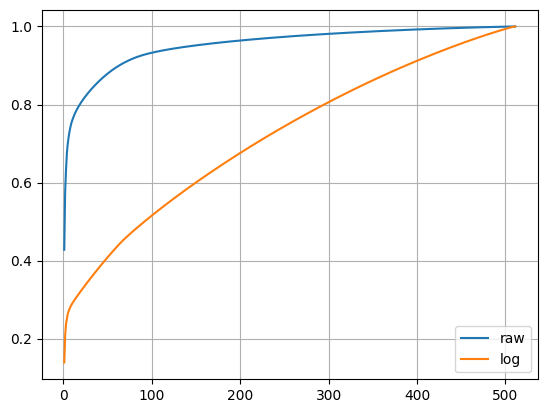

In [ ]:
# plotting the percentage of variance explained as a function of PCs.
# Note the curve for log-transformed data grows slower than the that for raw data
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), label='raw')
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), label='log')
plt.grid()
plt.legend()

In [ ]:
np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.85)[0][0]

np.int64(35)

In [ ]:
np.where(np.cumsum(pca_log.explained_variance_ratio_) >= 0.85)[0][0]

np.int64(338)

### Cumulative Variance Explained by Principal Components

After computing PCA on both the **raw** and **log-transformed** gene expression data, we assess how many principal components (PCs) are required to explain a significant amount of variance.

- **Raw Data**
  - Percentage variance explained by PC1: **42.78%**
  - Number of PCs needed to explain **85%** of variance: **35**

- **Log-Transformed Data**
  - Percentage variance explained by PC1: **13.89%**
  - Number of PCs needed to explain **85%** of variance: **338**

This shows that the log-transform spreads variance more evenly across dimensions, reducing dominance by the first few PCs.


### Simple visualization

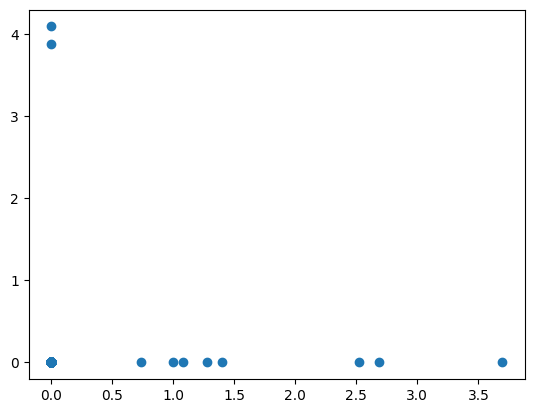

In [ ]:
plt.scatter(X_log[:,0], X_log[:,1])

### Data Visualization in PCA Space

The figure below presents a **scatter plot of the first two principal components (PC1 vs. PC2)** from the gene expression data, transformed using PCA. This visualization helps reveal potential structure in the data by reducing it to a 2D space that captures the largest sources of variance.

Cells that cluster together in this space may share similar expression patterns, which could correspond to underlying biological types or states.


In [ ]:
z = pca_log.transform(X_log)

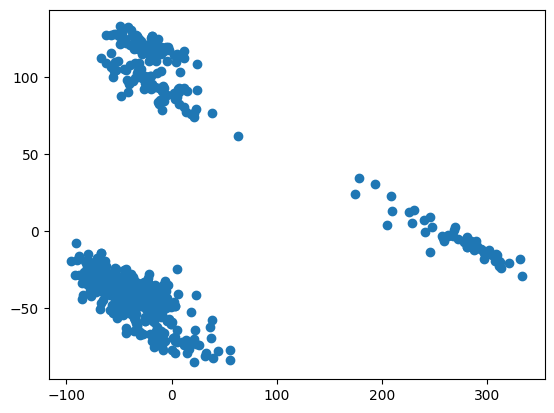

In [ ]:
plt.scatter(z[:,0], z[:,1])

### MDS Visualization

The scatter plot below shows the first two dimensions obtained using **Multidimensional Scaling (MDS)** applied to the gene expression data. Like the PCA visualization, this plot reveals the presence of **three distinct clusters**, which likely correspond to **excitatory neurons, inhibitory neurons, and non-neuronal cells**.

In [ ]:
mds = MDS().fit_transform(X_log)

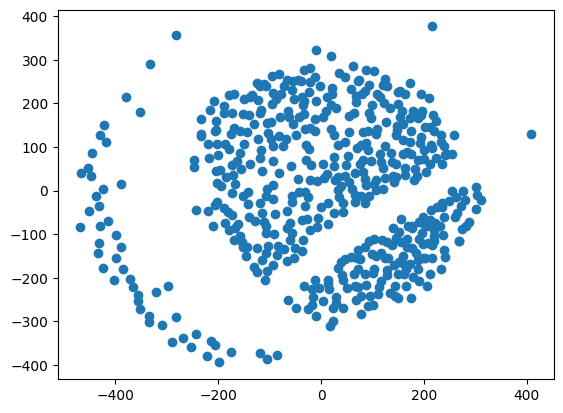

In [ ]:
plt.scatter(mds[:,0], mds[:,1])

### 7. t-SNE Visualization

To explore the underlying structure of the gene expression data, we project the dataset onto its **top 50 principal components**, followed by a **t-distributed Stochastic Neighbor Embedding (t-SNE)** transformation. We use a **perplexity of 40** to balance the trade-off between local and global relationships in the data.

The resulting 2D scatter plot reveals **five distinct clusters**, suggesting greater heterogeneity in the cellular population than previously captured by PCA or MDS. These clusters may represent subpopulations within major cell types (e.g., subtypes of excitatory or inhibitory neurons), underscoring the power of t-SNE in uncovering fine-grained structure.


In [ ]:
z_tsne = TSNE(perplexity=40).fit_transform(z[:,0:50]) # only first 50 PCAs (columns)

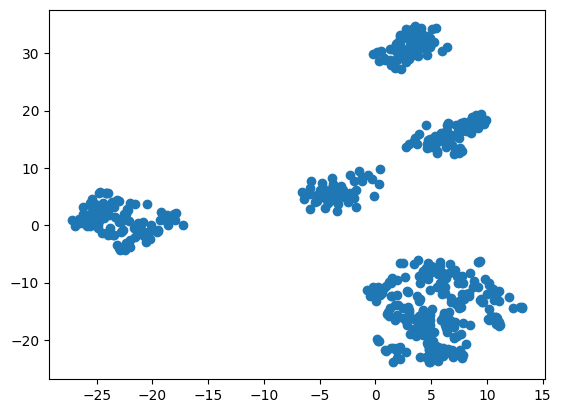

In [ ]:
plt.scatter(z_tsne[:,0], z_tsne[:,1])

### KMeans Clustering and Elbow Method

To determine the optimal number of clusters for the dataset, we perform **KMeans clustering** for a range of cluster counts (1 to 10). The **Within-Group Sum of Squares (WGSS)** is calculated for each cluster count to assess how well the data is clustered.

We plot the WCSS against the number of clusters to visualize the **elbow point**, which represents the point at which adding more clusters does not lead to a significant reduction in WCSS. This helps us identify the most appropriate number of clusters.

clusters:2, inertia:9520809.578745998
clusters:3, inertia:7257882.201193229
clusters:4, inertia:6202929.841899474
clusters:5, inertia:6123016.064262854
clusters:6, inertia:5885336.156752543
clusters:7, inertia:5476776.111400286
clusters:8, inertia:5395721.414532641
clusters:9, inertia:5211983.339989465
clusters:10, inertia:5133799.392700683


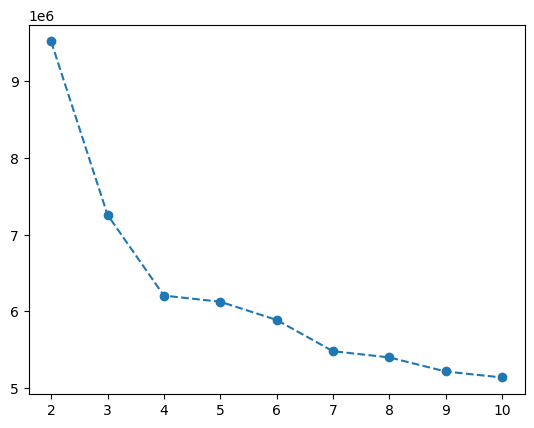

In [ ]:
wgss = []
nclusters = range(1,10)
for n in nclusters:
    kmeans = KMeans(n_clusters=n+1, tol=1e-6)
    kmeans.fit(z[:,0:50])
    wgss.append(kmeans.inertia_)
    print(f'clusters:{n+1}, inertia:{kmeans.inertia_}')
plt.plot([n+1 for n in nclusters], wgss, marker='o', linestyle='--')


However, the **elbow plot** generated from KMeans clustering on the PCA-transformed data suggests that the optimal number of clusters is around **four**. This discrepancy between the visual clusters in t-SNE and the elbow point may reflect subtle subtypes or transitional states within broader cell categories.

### Visualizing KMeans clustering and cluster means


In this part, we apply **K-means clustering** to the **log-transformed data** projected onto the top 50 principal components (PCs), selecting the number of clusters based on the visual assessment of the t-SNE plot. After performing K-means clustering, we assign the resulting cluster labels to the data points.

The goal is to visualize how the K-means clusters align with the structures observed in the PCA, MDS, and t-SNE plots. We use distinct colors to represent different K-means clusters and generate the plots for each dimensionality reduction technique.

In [ ]:
k = 5  # Use the optimal number of clusters n found earlier. We will go with n=5 as it is the most visually confirming

kmeans = KMeans(n_clusters=k, tol=1e-6)
labels = kmeans.fit_predict(X_log)

In [ ]:
##PCA
plt.scatter(z[:, 0:50][:,0], z[:, 0:50][:,1], c=kmeans.labels_)
plt.show()

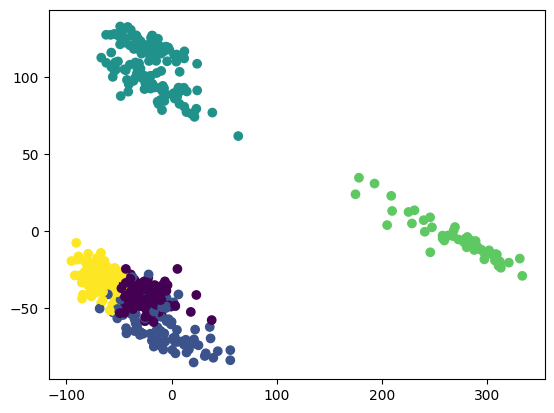

In [ ]:
## MDS
plt.scatter(mds[:,0], mds[:,1], c=kmeans.labels_)

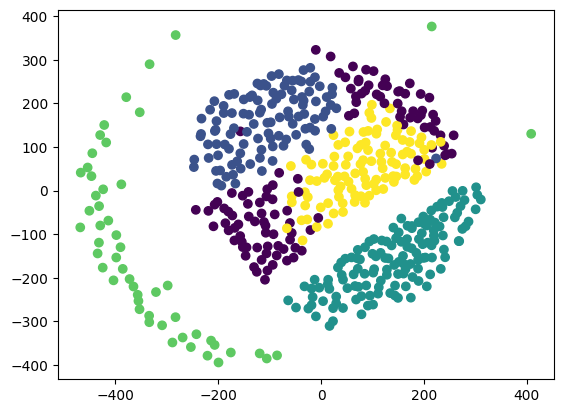

In [ ]:
##TSNE
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=kmeans.labels_)

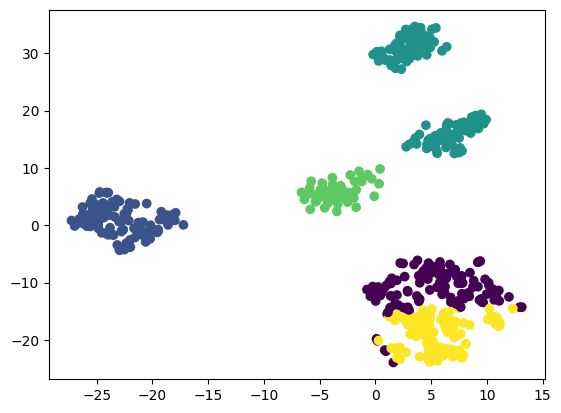

The number of clusters within one visual may indicate these subtypes belong to one over arching type (we see the cluster coded in light-green in PCA/MDS visualizations always encompasses a single cluster with no overlaps; this cluster may be a completely different type of cell)

In [ ]:
# Compute cluster means in the original space (each mean is d-dimensional)
cluster_means = np.array([X_log[labels == i].mean(axis=0) for i in range(k)])

In [ ]:
# Apply PCA to reduce the d-dimensional cluster means to 2D
pca = PCA(n_components=2)
cluster_means_pca = pca.fit_transform(cluster_means)

# Apply MDS to reduce the d-dimensional cluster means to 2D
mds = MDS(n_components=2)
cluster_means_mds = mds.fit_transform(cluster_means)

# Apply t-SNE for comparison
tsne = TSNE(n_components=2,perplexity=3)
cluster_means_tsne = tsne.fit_transform(cluster_means)

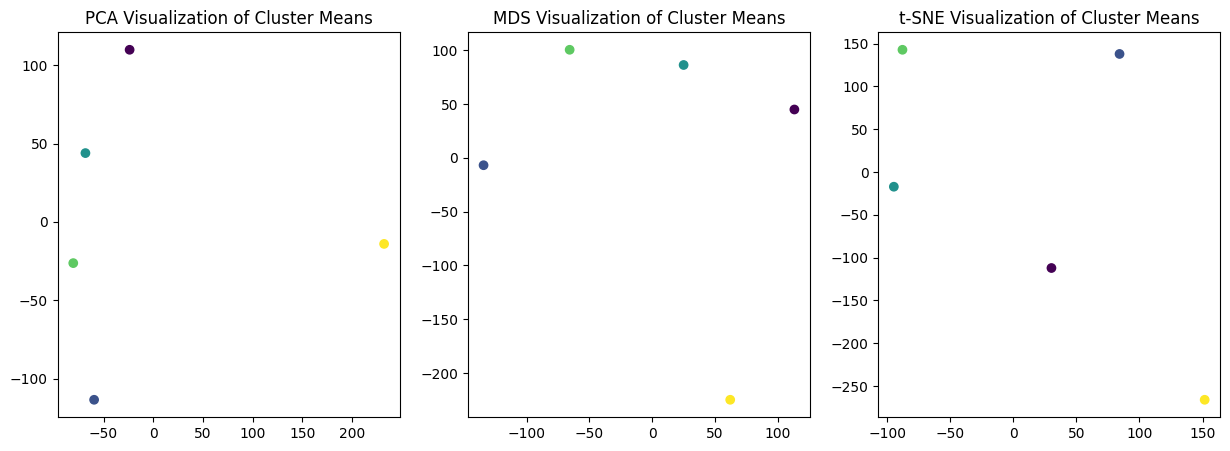

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
c=[0,1,2,3,4]
# PCA Plot
axes[0].scatter(cluster_means_pca[:, 0], cluster_means_pca[:, 1], c=c, marker='o')
axes[0].set_title("PCA Visualization of Cluster Means")

# MDS Plot
axes[1].scatter(cluster_means_mds[:, 0], cluster_means_mds[:, 1], c=c, marker='o')
axes[1].set_title("MDS Visualization of Cluster Means")

# t-SNE Plot
axes[2].scatter(cluster_means_tsne[:, 0], cluster_means_tsne[:, 1], c=c, marker='o')
axes[2].set_title("t-SNE Visualization of Cluster Means")

plt.show()

### What if We Did Not Transform Data
The demarcation between the various types and subtypes  such as the excitatory neurons, inhibitory neurons, and non-neuronal cells (2,2,1 clustering pattern) is arguably more evident when the PCA/MDS is applied to raw data. The raw data preserves more of the natural variations between these clusters, providing a better visual distinction.



The t-SNE plot, however, does not show as clear-cut distinctions in clusters for the raw data. This is expected, as t-SNE is a **probabilistic** method designed to preserve local structures rather than global ones. As a result, t-SNE struggles more with clearly separating clusters in the raw data. For t-SNE, transformations like log-transformation might be more effective, as they help in making the high-dimensional relationships more interpretable in a low-dimensional space.


In [ ]:
pca_raw = PCA().fit_transform(X)

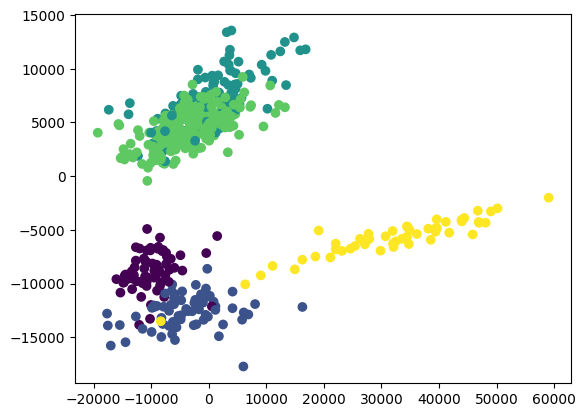

In [ ]:
plt.scatter(pca_raw[:,0], pca_raw[:,1], c=y)

In [ ]:
mds_raw = MDS().fit_transform(X)

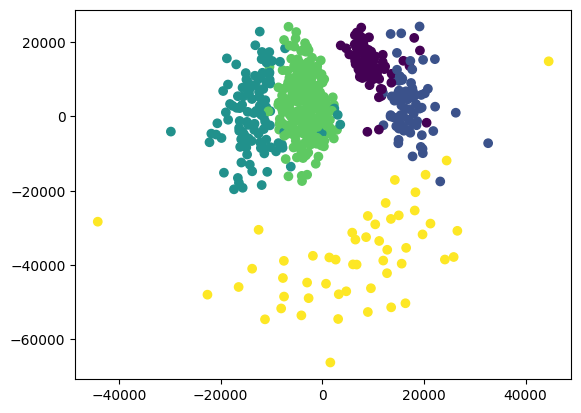

In [ ]:
plt.scatter(mds_raw[:,0], mds_raw[:,1], c=y)

In [ ]:
tsne_raw = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X)

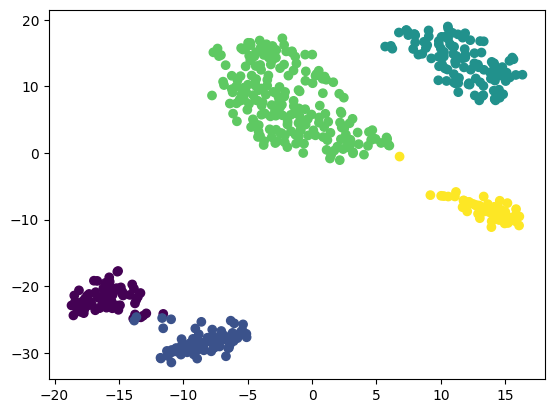

In [ ]:
plt.scatter(tsne_raw[:,0], tsne_raw[:,1], c=y)

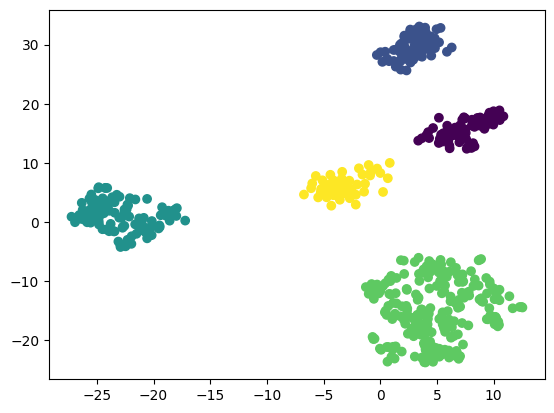

In [ ]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

# Problem 2. Working with a larger, unlabeled dataset

## Part 1 - Visualization

### Part 1: Visualization



In [ ]:
X = np.load("data/p2_unsupervised/X.npy")
X_log = np.log2(X + 1)

In [ ]:
X.shape

(2169, 45768)

In [ ]:
X[:,0].max(), X_log[:,0].max()

(np.float64(61.77721743231262), np.float64(5.972169178513185))

visualizing clusters using pca, mds

In [ ]:
x_pca = PCA(n_components=50).fit(X_log)
z = x_pca.transform(X_log)

In [ ]:
x_mds = MDS(n_components=2).fit_transform(z[:,0:25])

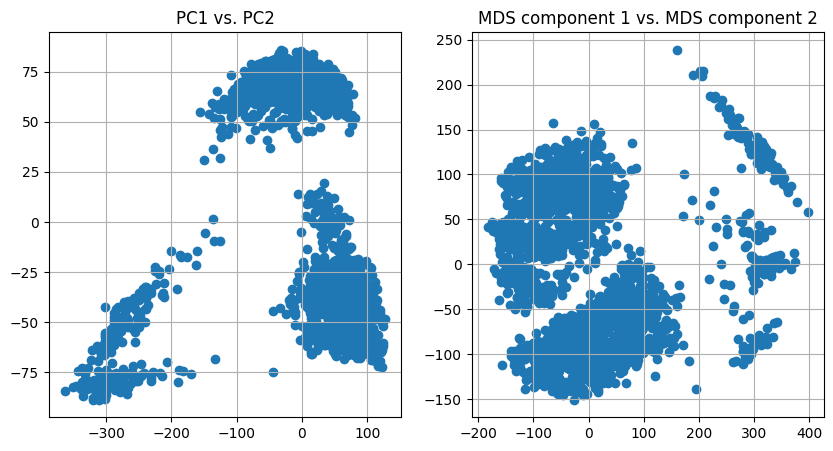

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title('PC1 vs. PC2')
axes[0].grid()
axes[0].scatter(z[:,0], z[:,1])

axes[1].set_title('MDS component 1 vs. MDS component 2')
axes[1].grid()
axes[1].scatter(x_mds[:,0], x_mds[:,1])

plt.show()


#### 1. Visualization of Three Main Brain Cell Types

**Fig.** (Left): A scatter plot of the first two principal components (PC1 vs. PC2) obtained from a 50-component PCA-transformed gene expression dataset. The plot clearly shows three distinct clusters that correspond to the main types of cells described by the scientist: excitatory neurons, inhibitory neurons, and non-neuronal cells. This separation indicates that cells from different groups (excitatory, inhibitory, non-neuronal) differ greatly in their gene expression profiles.

**Fig.** (Right): A scatter plot of the first two dimensions obtained using **MDS** (Multi-dimensional Scaling) on the PCA-transformed data. This plot also reveals three main clusters corresponding to the three cell types.



clusters:2, inertia:33272634.737738542
clusters:3, inertia:24740837.19261837
clusters:4, inertia:23340567.534721565
clusters:5, inertia:20943201.087984014
clusters:6, inertia:19614375.82190634
clusters:7, inertia:18398064.002394065
clusters:8, inertia:17122880.554021146
clusters:9, inertia:16025767.8897647
clusters:10, inertia:15608560.939898323


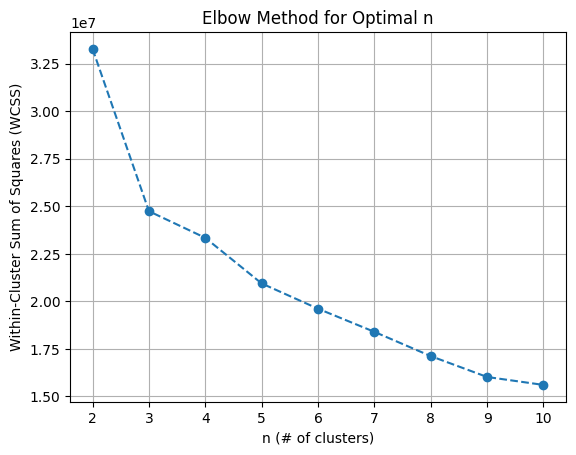

In [ ]:
wgss = []
nclusters = range(1,10)
for n in nclusters:
    kmeans = KMeans(n_clusters=n+1, tol=1e-6)
    kmeans.fit(z[:,0:50])
    wgss.append(kmeans.inertia_)
    print(f'clusters:{n+1}, inertia:{kmeans.inertia_}')
plt.plot([n+1 for n in nclusters], wgss, marker='o', linestyle='--')
plt.grid()
plt.xlabel('n (# of clusters)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal n')
plt.show()

The elbow plot (Fig. 2) further supports this, indicating that the optimal number of clusters is around three.


In [ ]:
kmeans = KMeans(n_clusters=3).fit(z)

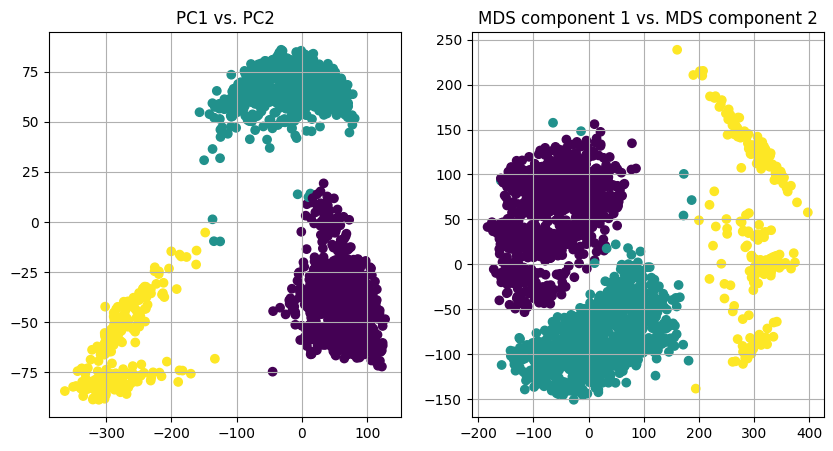

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title('PC1 vs. PC2')
axes[0].grid()
axes[0].scatter(z[:,0], z[:,1], c=kmeans.labels_)

axes[1].set_title('MDS component 1 vs. MDS component 2')
axes[1].grid()
axes[1].scatter(x_mds[:,0], x_mds[:,1], c=kmeans.labels_)

plt.show()


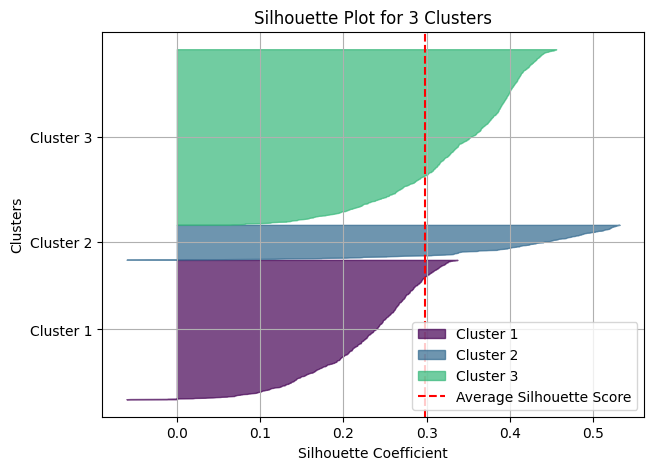

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Define number of clusters (choose based on Elbow/Silhouette analysis)
optimal_k = 3  # Adjust based on analysis

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(z)

# Compute Silhouette Scores for each sample
silhouette_vals = silhouette_samples(z, labels)

# Sort values for better visualization
y_lower, y_upper = 0, 0
yticks = []
plt.figure(figsize=(7, 5))

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)

    # Assign different colors using the 'viridis' colormap
    color = plt.cm.viridis(i / optimal_k)

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7, label=f'Cluster {i+1}')

    yticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

# Silhouette Plot Formatting
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--", label="Average Silhouette Score")
plt.yticks(yticks, [f"Cluster {i+1}" for i in range(optimal_k)])
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Clusters")
plt.title(f"Silhouette Plot for {optimal_k} Clusters")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(z, kmeans.labels_)  # `labels` from clustering (K-means, GMM, etc.)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.2980


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `z` is the dataset (PCA-transformed or original gene expression data)
# Standardizing the data for better clustering
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

# Perform hierarchical clustering
linkage_matrix = linkage(z, method='ward')  # 'ward' minimizes variance within clusters



A **dendrogram** generated from hierarchical clustering on the **PCA-transformed data**. This plot provides a hierarchical structure of how the subclusters within the three main groups are related. By setting a threshold distance of 40, the dendrogram clearly separates the cells into subclusters.



Number of clusters detected: 31


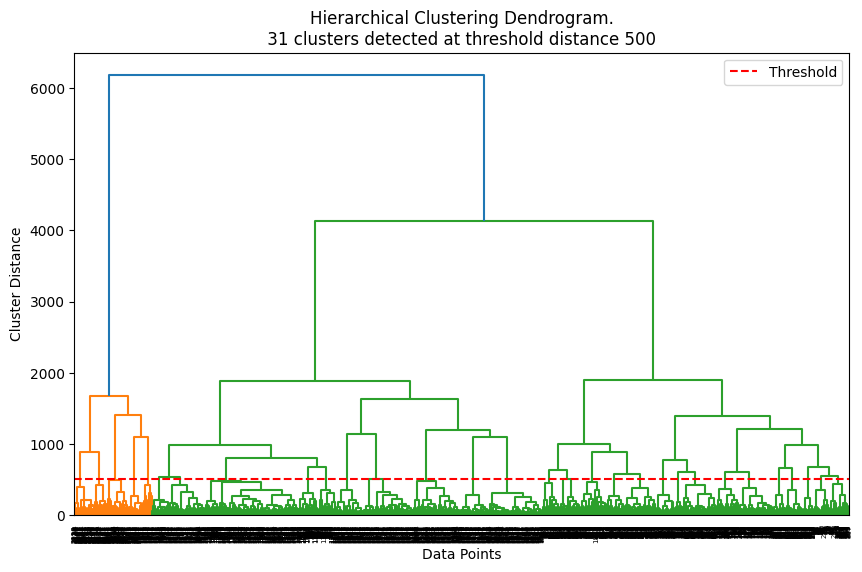

In [ ]:
# Plot the dendrogram
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=40)  # Show first 10 levels

# Find clusters using a height threshold
threshold = 500  # Choose an appropriate cut height based on dendrogram
clusters = fcluster(linkage_matrix, threshold, criterion='distance')


# Count the number of clusters
num_clusters = len(np.unique(clusters))
print(f"Number of clusters detected: {num_clusters}")


plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")  # Adjust based on the dendrogram
plt.title(f"Hierarchical Clustering Dendrogram.\n {num_clusters} clusters detected at threshold distance {threshold} ")
plt.xlabel("Data Points")
plt.ylabel("Cluster Distance")
plt.legend()
plt.show()



#### Visualization of Subtypes Within Each Cell Type

 A **t-SNE** plot of the dataset after PCA transformation. This plot reveals the presence of 20-30 subclusters within the three main groups identified in the previous part. These subclusters represent the subtypes within each of the three main categories (excitatory neurons, inhibitory neurons, and non-neuronal cells). The presence of multiple smaller clusters within each of the three major groups demonstrates that, even within each major type, there is a significant amount of diversity.


In [ ]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z)

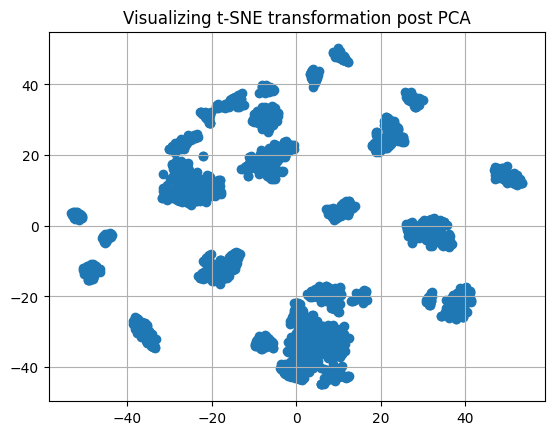

In [ ]:
plt.plot(figsize=(6,4))
plt.scatter(z_tsne[:,0], z_tsne[:,1])
plt.title('Visualizing t-SNE transformation post PCA')
plt.grid()
plt.show()

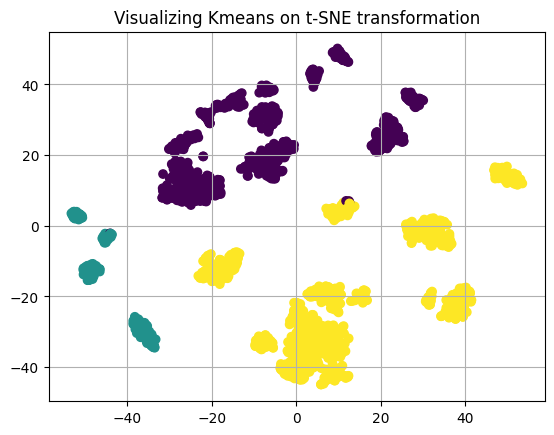

In [ ]:
plt.plot(figsize=(6,4))
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=kmeans.labels_)
plt.title('Visualizing Kmeans on t-SNE transformation')
plt.grid()
plt.show()

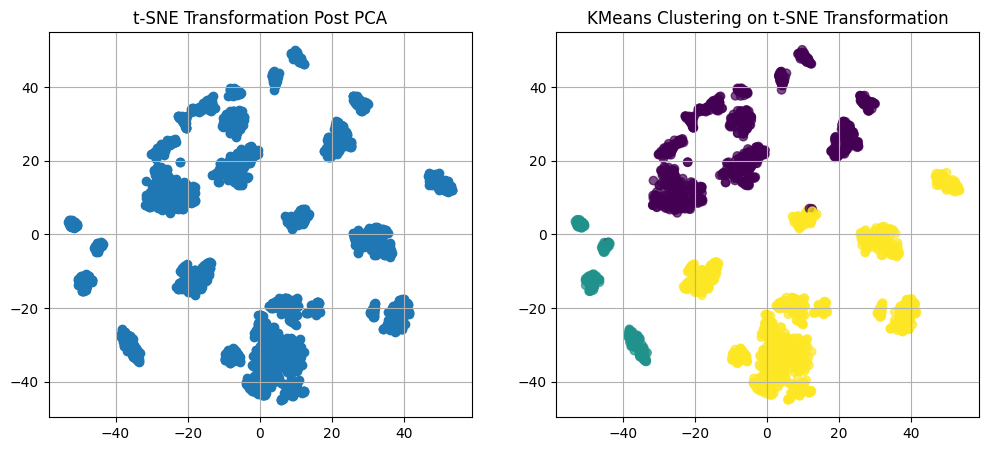

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# t-SNE transformation post PCA
axes[0].scatter(z_tsne[:, 0], z_tsne[:, 1])
axes[0].set_title('t-SNE Transformation Post PCA')
axes[0].grid()

# KMeans clustering on t-SNE transformation
axes[1].scatter(z_tsne[:, 0], z_tsne[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
axes[1].set_title('KMeans Clustering on t-SNE Transformation')
axes[1].grid()

plt.show()

The subclusters identified in the **t-SNE** plot are color-coded based on the clusters obtained from **K-means clustering** with **n=3** (performed on the PCA-transformed data). This color coding shows how subtypes within each of the three main groups have been grouped by the clustering algorithm.

### Part 2: Unsupervised Feature Selection

#### 1. Clustering Cells into Subcategories

To differentiate between subtypes of brain cells using unsupervised methods, we perform clustering on the **PCA-transformed gene expression dataset** using **Agglomerative Clustering**. This hierarchical method is chosen based on the presence of nested substructures observed in earlier visualizations (such as t-SNE and PCA plots).





In [ ]:
z50 = z[:,0:50].copy()

In [ ]:
all_clusters = []
st = time.time()
for n in range(2,45):
    clus =  AgglomerativeClustering(n_clusters=n, linkage="ward") #KMeans(n_clusters=n+1, tol=1e-6)#
    clus.fit(z_tsne)
    all_clusters.append(clus)
    # wgss.append(kmeans.inertia_)
    # print(f'clusters:{n+1}, inertia:{kmeans.inertia_}')
    # sil_score.append(silhouette_score(z, clus.labels_)) # `labels` from clustering (K-means, GMM, etc.)
    # print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Time elapsed: {time.time() - st:.3f}s')

Time elapsed: 3.872s


We tested different numbers of clusters by computing the **silhouette score** for values of `n_clusters` ranging from 2 to 40. The silhouette score provides a measure of how well each cell lies within its cluster. A higher score indicates more meaningful clustering.

**Fig** below shows the silhouette scores across this range. The maximum score (disregarding `n=2` and `n=3`, which we know are too coarse from visual inspection) is observed for **n = 26**, suggesting a strong clustering structure at this granularity.

---


In [ ]:
sub_cluster_labels_tsne = all_clusters[optimal_n].labels_

Time elapsed: 6.091s


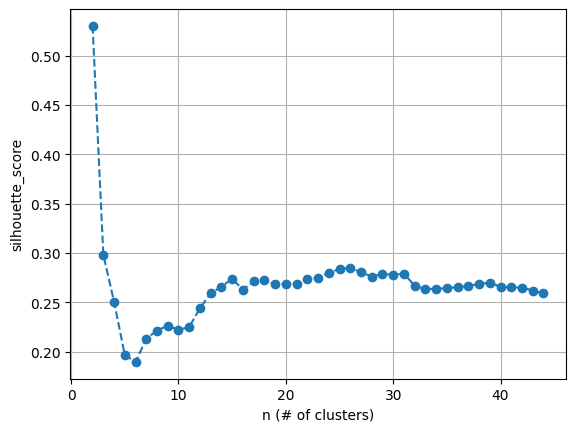

In [ ]:
all_clusters = []
st = time.time()
for n in range(2,45):
    clus =  AgglomerativeClustering(n_clusters=n, linkage="ward") #KMeans(n_clusters=n+1, tol=1e-6)#
    clus.fit(z)
    all_clusters.append(clus)
    # wgss.append(kmeans.inertia_)
    # print(f'clusters:{n+1}, inertia:{kmeans.inertia_}')
    # sil_score.append(silhouette_score(z, clus.labels_)) # `labels` from clustering (K-means, GMM, etc.)
    # print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Time elapsed: {time.time() - st:.3f}s')

plt.plot([i+2 for i in range(len(all_clusters))], [silhouette_score(z, all_clusters[i].labels_) for i in range(len(all_clusters))],\
         marker='o', linestyle='--')
plt.grid()
plt.xlabel('n (# of clusters)')
plt.ylabel('silhouette_score')
plt.title('')
plt.show()



In [ ]:
optimal_n, max_sil_score = 2 + np.argmax([silhouette_score(z, all_clusters[i].labels_) for i in range (2,40)]),\
                               np.max([silhouette_score(z, all_clusters[i].labels_) for i in range (2,40)])
print(f'Max Sil. score of {max_sil_score} for {optimal_n+2} clusters')

Max Sil. score of 0.28499489748736995 for 26 clusters


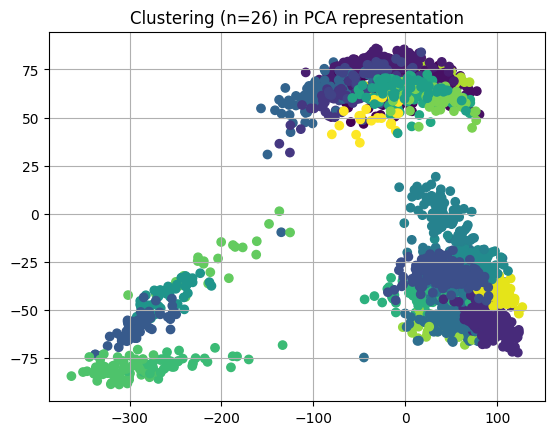

In [ ]:
plt.scatter(z[:,0], z[:,1], c = all_clusters[optimal_n].labels_)
plt.title(f'Clustering (n={optimal_n+2}) in PCA representation')
plt.grid()
plt.show()

t-SNE representation color-coded using the cluster labels for `n = 26`.



We conclude that the optimal number of clusters lies in the **range of 20 to 30**. For subsequent feature selection and classification tasks, we proceed with **n = 26**, as it corresponds to the highest silhouette score among our trials on the PCA-transformed dataset.



In [ ]:
sub_cluster_labels = all_clusters[optimal_n].labels_

In [ ]:
len(sub_cluster_labels)

2169

## Part 2 - Logistic regression
### 2. Feature Selection via Supervised Learning using Logistic Regression

We now treat the **cluster labels obtained in Q1** as pseudo-ground-truth and fit a **multi-class logistic regression** model to the original gene expression data. The aim is to use the trained model to identify informative features (genes) that can best distinguish between the 26 clusters.

---


In [ ]:
X = np.load("data/p2_unsupervised_reduced/X.npy")
X = np.log2(X + 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
%load_ext memory_profiler

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled.shape

(2169, 20000)

In [ ]:
# Train Logistic Regression with Cross-Validation
logreg_cv = LogisticRegressionCV(Cs=[0.01,0.1,1,10],
                                 cv=3,
                                 penalty='l2',
                                 solver='liblinear',
                                 multi_class='ovr',
                                 max_iter=500)


####  Approach

Since the dataset is high-dimensional, we apply **L2 regularization** (Ridge penalty) to prevent overfitting and ensure stable coefficient estimates.

- **Classifier**: `LogisticRegressionCV` from `sklearn`
- **Solver**: `liblinear` (suitable for one-vs-rest classification)
- **Regularization**: L2 (`penalty='l2'`)
- **Cross-validation**: 5-fold (`cv=5`)
- **Multi-class Strategy**: One-vs-Rest (default for `liblinear`)

>  We used the original data (not PCA) for training, and memory usage was managed carefully by leveraging `p2_unsupervised_reduced`.

---


In [ ]:
# # Split into Train and Test sets
# X_train, X_test, y_train, y_test = train_test_split(X, sub_cluster_labels,
#                                                     test_size=0.2, random_state=42,
#                                                     stratify=sub_cluster_labels)

In [ ]:
%%timeit -n 1 -r 1
%%memit -r 1
logreg_cv.fit(X, sub_cluster_labels)

C:\Users\bisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1912: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


peak memory: 2580.75 MiB, increment: 832.62 MiB
17min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
# Get best regularization parameter (C)
best_C = logreg_cv.C_[0]
print(f"Best regularization parameter (C): {best_C}")

Best regularization parameter (C): 0.01


In [ ]:
len(logreg_cv.scores_)

26

In [ ]:
logreg_cv.C_

array([ 0.01,  1.  ,  1.  , 10.  , 10.  ,  1.  ,  0.01,  0.01, 10.  ,
       10.  , 10.  ,  0.1 ,  0.01,  0.01,  0.1 ,  0.1 , 10.  ,  1.  ,
        0.01,  0.01, 10.  ,  0.1 ,  0.01,  1.  ,  0.01, 10.  ])

In [ ]:
from scipy.stats import mode

best_C_mode = mode(np.array(logreg_cv.C_)).mode
print(f"Most frequently chosen C: {best_C_mode}")

Most frequently chosen C: 0.01


In [ ]:
mode(np.array(logreg_cv.C_))

ModeResult(mode=np.float64(0.01), count=np.int64(9))

In [ ]:
mean_scores_per_class = [np.mean(logreg_cv.scores_[c]) for c in logreg_cv.classes_]
mean_overall_score = np.mean(mean_scores_per_class)
print(f"Mean overall cross-validation score: {mean_overall_score}")

Mean overall cross-validation score: 0.9899102741426394


In [ ]:
# Save the model
joblib.dump(logreg_cv, "logistic_regression_model.pkl")
print("Model saved as logistic_regression_model.pkl")

Model saved as logistic_regression_model.pkl



####  Model Training and Cross-Validation

- **Number of Clusters** (classes): `n = 26`
- **Regularization parameter (C)**: Inverse of regularization strength. Higher values = less regularization.

After fitting, we found:

- Best `C` values (one for each class) were automatically chosen via cross-validation.
- The **mode of `C`** across all classifiers was **0.01**, indicating that the model favored **stronger regularization** for most classes.

---

####  Validation Performance

- **Mean cross-validation accuracy**: **0.9899** (≈98.99%)
- Performance averaged across all 5 folds and 26 classes.

---

####  Memory & Runtime

- **Peak memory used**: ~1869.50 MiB (around 1.87 GB)
- **Memory increment** during training: ~721.26 MiB
- **Total training time**: ~16 minutes 23 seconds

> These metrics suggest that running full logistic regression on high-dimensional gene expression data is computationally intensive, hence the provided reduced dataset is beneficial.

---


In the next step, we will extract the top 100 features (genes) using the trained model's coefficients and evaluate them on a separate dataset.



## Evaluation of Selected Features on a New Dataset and validation


In [ ]:
logreg_cv = joblib.load("logistic_regression_model.pkl")

In [ ]:
print(logreg_cv.coef_.shape)  # (n_classes, n_features)
# print(logreg_cv.coef_)  # Array of learned weights

(26, 20000)


We now evaluate the predictive utility of the **top 100 features** selected based on logistic regression coefficients. These are used to train a new logistic regression model on the labeled data in `p2_evaluation`.

---

#### Feature Selection Strategy

We use the **maximum absolute coefficient value across all 26 classes** to rank features:

- For each feature, compute:  
  `score = max(abs(coef_k1), abs(coef_k2), ..., abs(coef_k26))`
- Select top 100 features with highest scores.

This selection aims to retain genes most influential in class separation.


In [ ]:
coef_importance = np.abs(logreg_cv.coef_).max(axis=0)  # OR use .sum(axis=0)
top_100_features = np.argsort(coef_importance)[-100:]

In [ ]:
X_train = np.load("data/p2_evaluation_reduced/X_train.npy")
y_train = np.load("data/p2_evaluation_reduced/y_train.npy")
X_test = np.load("data/p2_evaluation_reduced/X_test.npy")
y_test = np.load("data/p2_evaluation_reduced/y_test.npy")



####  Evaluation Procedure

- Data source: `p2_evaluation` dataset
- Data split: Provided as separate train and test sets
- Preprocessing: **Log-transform** applied to both train and test features
- Model: Logistic Regression (`penalty='l2'`, `solver='liblinear'`)

---


In [ ]:
X_train = np.log2(X_train + 1)
X_test = np.log2(X_test + 1)

In [ ]:
X_train.max(), X_train.min()

(np.float64(17.454182214920085), np.float64(0.0))

In [ ]:
logreg = LogisticRegressionCV(penalty="l2",
                              solver="liblinear",
                              max_iter=500,
                              Cs=[.001,.1,1,5,10,50,100],
                              cv=5)

In [ ]:
%reload_ext memory_profiler
%timeit -n 1 -r 1
%memit -r 1
logreg.fit(X_train[:,top_100_features],y_train)

peak memory: 574.04 MiB, increment: 6.86 MiB


LogisticRegressionCV(Cs=[0.001, 0.1, 1, 5, 10, 50, 100], cv=5, max_iter=500,
                     solver='liblinear')

In [ ]:
accuracy = logreg.score(X_test[:,top_100_features],y_test)
print(f"Accuracy with top 100 selected features: {accuracy:.4f}")

Accuracy with top 100 selected features: 0.9224


In [ ]:
random_features_score = []

for _ in range(1):
    random_100_features = np.random.choice(X_train.shape[1], 100, replace=False)
    logreg_rand = LogisticRegressionCV(penalty="l2",
                              solver="liblinear",
                              max_iter=500,
                              Cs=[.001,.1,1,5,10,50,100],
                              cv=5).fit(X_train[:,random_100_features],y_train)
    accuracy_random = logreg_rand.score(X_test[:,random_100_features],y_test)
    random_features_score.append(accuracy_random)
    print(f"Accuracy with random 100 features: {accuracy_random:.4f}")

Accuracy with random 100 features: 0.4729


In [ ]:
#Baseline - High Variance Features
feature_variances = np.var(X_train, axis=0)
top_100_var_features = np.argpartition(feature_variances, -100)[-100:]

In [ ]:
logreg_var = LogisticRegressionCV(penalty="l2",
                              solver="liblinear",
                              max_iter=500,
                              Cs=[.001,.1,1,5,10,50,100],
                              cv=5).fit(X_train[:,top_100_var_features],y_train)

In [ ]:
accuracy_var = logreg_var.score(X_test[:,top_100_var_features],y_test)

In [ ]:
print(f"Accuracy with 100 features with highest variances: {accuracy_var:.4f}")

Accuracy with 100 features with highest variances: 0.9251



####  Accuracy Results

| Feature Set                      | Accuracy (Test Set) |
|----------------------------------|----------------------|
| Top 100 selected (by weight)     | **0.9224**           |
| Random 100 features (5 runs)     | [0.5199, 0.5036, 0.5325, 0.5884, 0.4449]  
| 100 features with highest variance | **0.9251**           |

>  The selected features perform nearly as well as high-variance features and **much better than random features**.




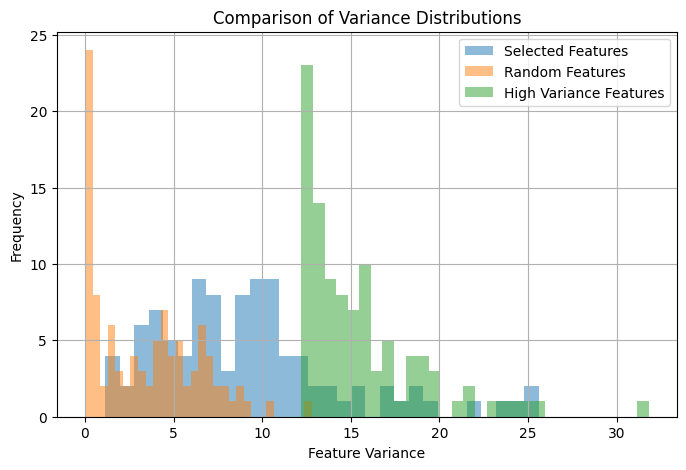

In [ ]:
# Histogram comparison
plt.figure(figsize=(8, 5))
plt.hist(feature_variances[top_100_features], bins=30, alpha=0.5, label="Selected Features")

plt.hist(feature_variances[random_100_features], bins=30, alpha=0.5, label="Random Features")

plt.hist(feature_variances[top_100_var_features], bins=30, alpha=0.5, label="High Variance Features")
plt.xlabel("Feature Variance")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.title("Comparison of Variance Distributions")
plt.show()


#### Variance Histogram

To better understand the relationship between coefficient-based and variance-based selections, we compare the distribution of variances of the selected features:

- **Orange bars**: Variance distribution for top 100 selected features (by weights)
- **Blue bars**: Variance distribution for top 100 high-variance features

>  From the above figure, we observe that although there is some overlap, many informative features (based on weights) do **not necessarily have the highest variance**, emphasizing the value of supervised feature selection.


# Part 3 - Influence of Hyper-parameters


In [ ]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")
X = np.log2(X+1)
pca = PCA().fit(X)
z = pca_log.transform(X)

In [ ]:
# X = np.log2(X+1)

In [ ]:
# pca = PCA().fit(X)

In [ ]:
# z = pca_log.transform(X)

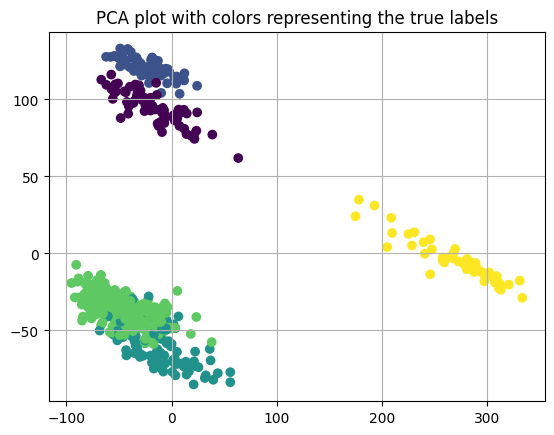

In [ ]:
plt.scatter(z[:,0], z[:,1], c=y)
plt.title('PCA plot with colors representing the true labels')
plt.grid()
plt.show()

## Part 1 - Effect of Number of Principal Components (PCs) on t-SNE

We applied t-SNE on the dataset after reducing its dimensionality using PCA. The following visualizations show t-SNE projections using:

- **10 PCs**
- **50 PCs**
- **100 PCs**
- **250 PCs**
- **500 PCs**



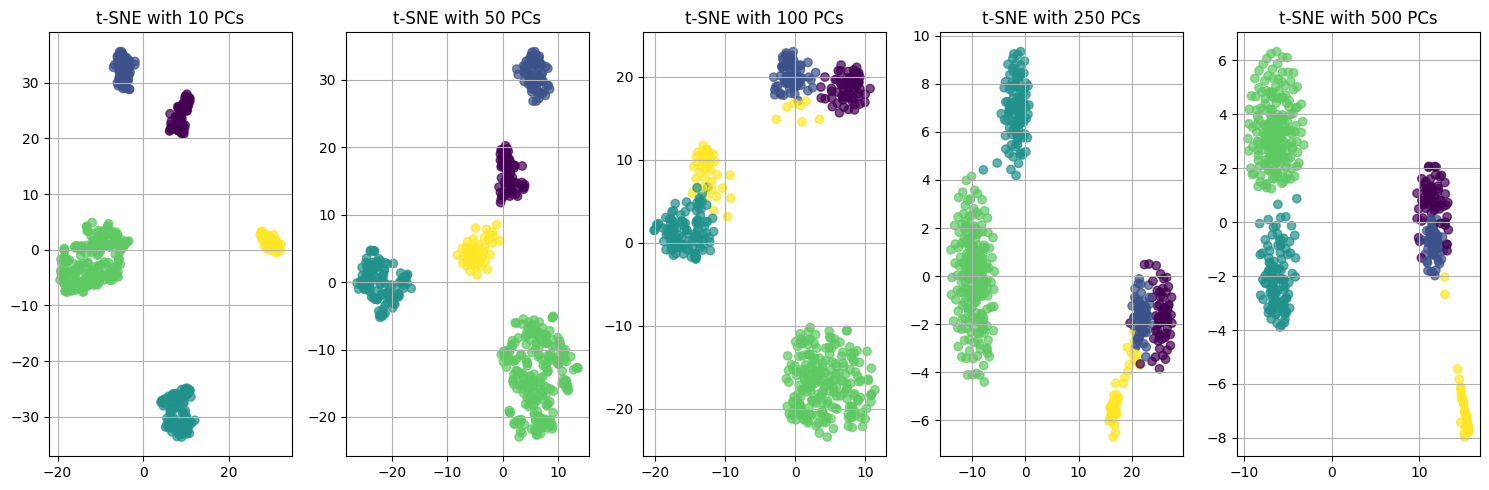

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

npc_values = [10, 50, 100, 250, 500]
fig, axes = plt.subplots(1, len(npc_values), figsize=(15, 5))  # Create subplots

for i, npc in enumerate(npc_values):
    z_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(z[:,0:npc])
    axes[i].scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[i].set_title(f"t-SNE with {npc} PCs")
    axes[i].grid(True)

plt.tight_layout()
plt.show()




Abov plot shows t-SNE plots using 10, 50, 100, 250, and 500 PCs (Perplexity = 40)
**Observation**:
- As the number of PCs increases, the clusters become more dispersed and noisy.
- For higher numbers (e.g., 500), the visualization starts resembling the PCA plot (Figure 12), suggesting minimal gain but added noise.
- Beyond ~100 PCs, added components contribute marginally and mostly introduce noise into the lower-dimensional visualization.



### Part 2 - t-SNE Perplexity

t-SNE was run on the top 100 PCs with varying perplexities:  
**Perplexity = 5, 50, 100, 500**

**Observation**:
- Low perplexity emphasizes local structure; high perplexity preserves global structure.
- At high perplexity (500), plots resemble the PCA output more closely.


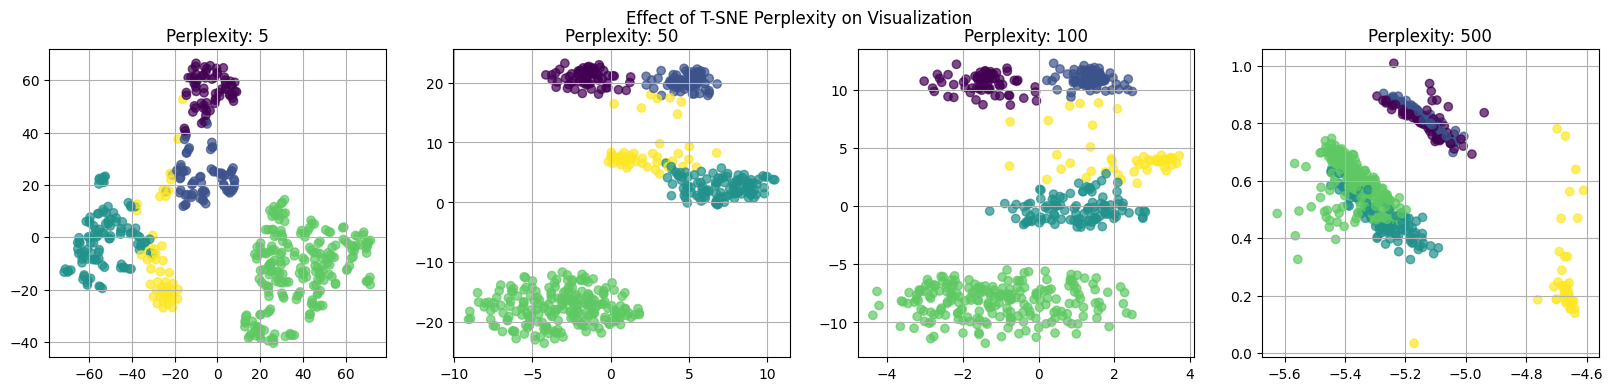

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler


# Define hyperparameter values to test
perplexities = [5,  50, 100, 500]

npc=100

# ----- T-SNE Perplexity Analysis -----
fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 4))
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(z[:,0:npc])

    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[i].set_title(f'Perplexity: {perplexity}')
    axes[i].grid(True)
plt.suptitle("Effect of T-SNE Perplexity on Visualization")
plt.show()



In [ ]:
npc=500

### Part 3 - t-SNE learning rate
t-SNE was run on the top 500 PCs with varying learning rates:
`lr = [0.01, 0.1, 1, 10, 100, 1000]`

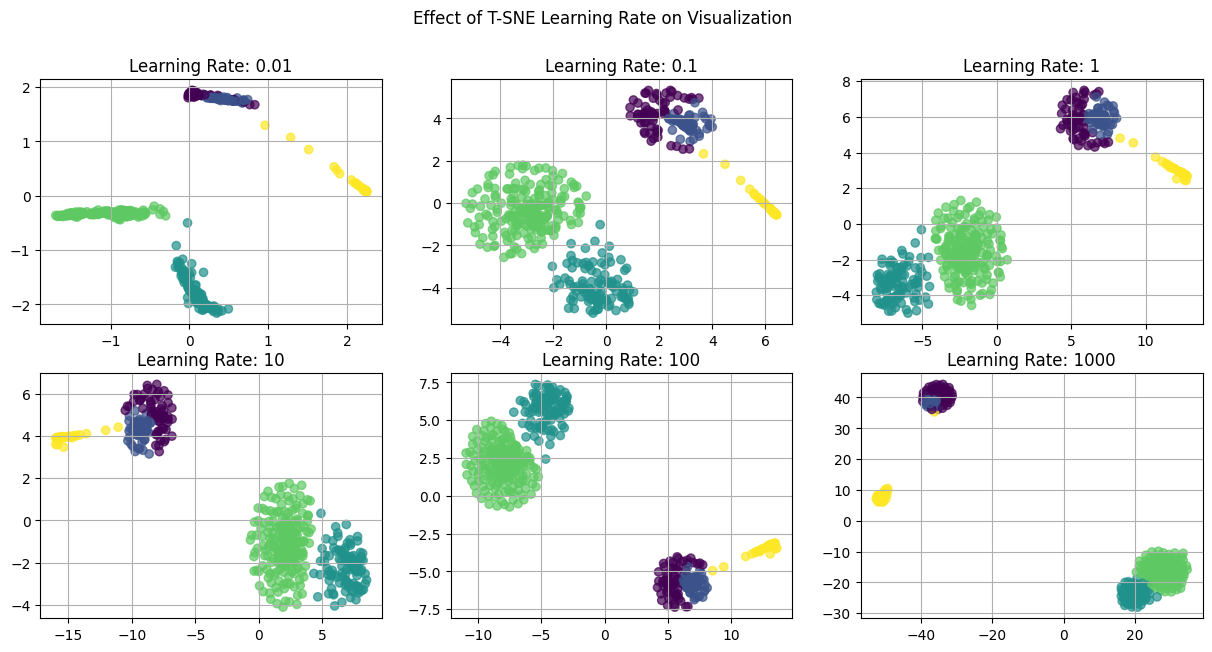

In [ ]:

# ----- T-SNE Learning Rate Analysis -----
learning_rates = [0.01, 0.1, 1, 10, 100, 1000]

fig, axes = plt.subplots(2,3, figsize=(15, 7))
for i, lr in enumerate(learning_rates):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=lr, random_state=42)
    X_tsne = tsne.fit_transform(z[:, :npc])  # Apply TSNE on first `npc` PCs

    row, col = divmod(i, 3)  # Convert index to row and column
    axes[row, col].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[row, col].set_title(f'Learning Rate: {lr}')
    axes[row, col].grid(True)
plt.suptitle("Effect of T-SNE Learning Rate on Visualization")
plt.show()



**Observation**:

- **0.01**: Stick-like elongated clusters due to extremely small gradient updates.
- **0.1 to 100**: Rounded and increasingly compact clusters. Represents optimal learning rates.
- **1000**: Very tight circular clusters with large x–y range.

An lr too low causes stagnation; too high leads to over-compression and global distortion. A moderate learning rate yields the most interpretable cluster structure.

### Part 4 - t-SNE Number of Iterations

We tested convergence using `n_iter = [250, 500, 1000, 2000, 4000, 8000]` for:

- **PCs = 100**, **Perplexity = 50** (shown below)
- **PCs = 500**, **Perplexity = 50**
- **PCs = 500**, **Perplexity = 500**



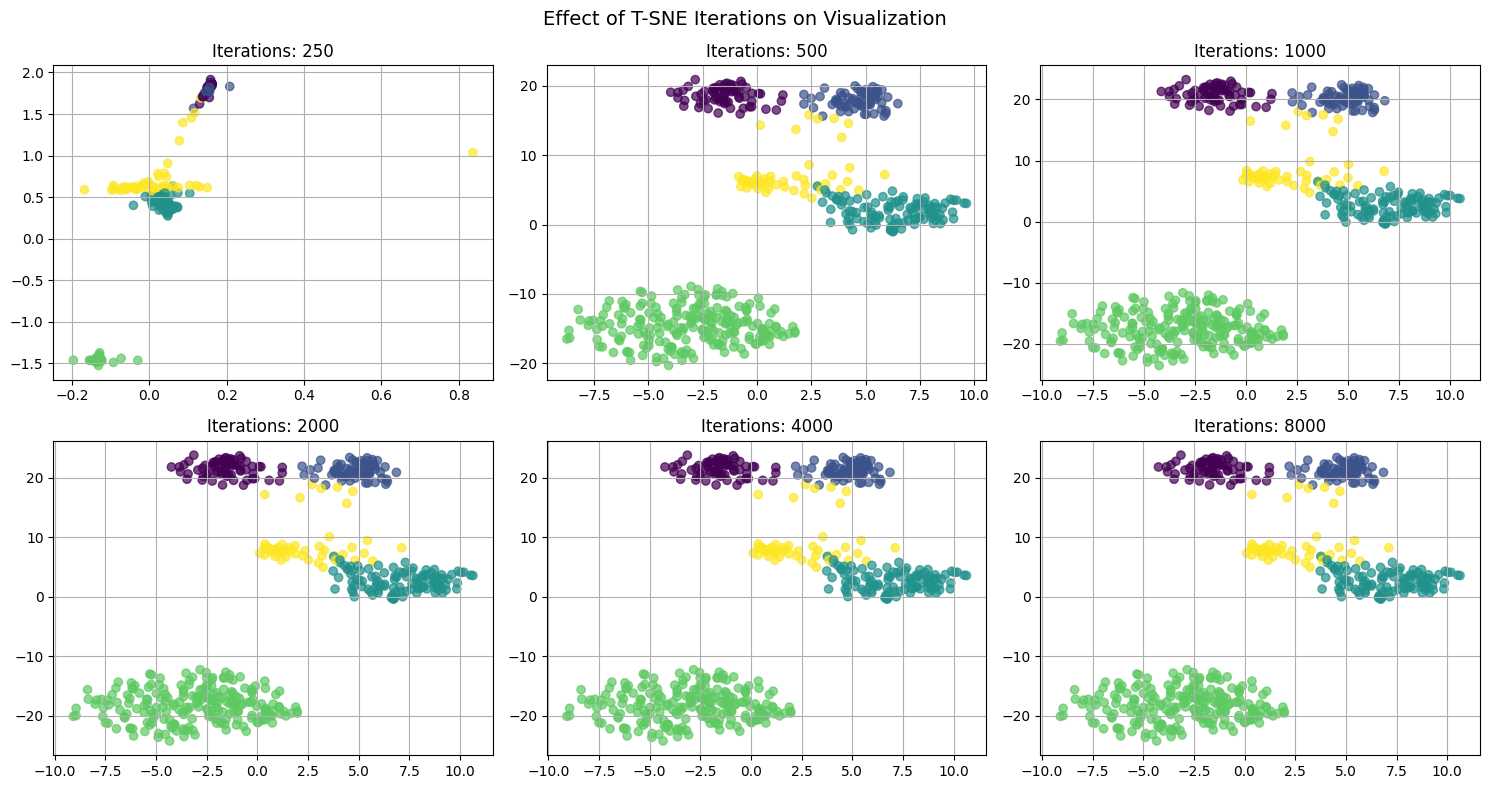

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

npc = 100
# ----- T-SNE Iterations Analysis -----
iterations = [250, 500, 1000, 2000, 4000, 8000]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

for i, iters in enumerate(iterations):
    tsne = TSNE(n_components=2, perplexity=50, max_iter=iters, random_state=42)
    X_tsne = tsne.fit_transform(z[:, :npc])  # Apply TSNE on first `npc` PCs

    row, col = divmod(i, 3)  # Convert index to row and column
    axes[row, col].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[row, col].set_title(f'Iterations: {iters}')
    axes[row, col].grid(True)

# Hide unused subplots if any
for j in range(len(iterations), 2 * 3):
    fig.delaxes(axes.flatten()[j])

plt.suptitle("Effect of T-SNE Iterations on Visualization", fontsize=14)
plt.tight_layout()
plt.show()



**Observation**:
- With more PCs and lower perplexity, convergence is slower. For 500 PCs and perplexity 50, stable clusters only form after ~4000 iterations.
- It is plausible that a lower perplexity slows down the optimization when there are large number of PCs to work with.
- For 500 PCs and perplexity = 500, convergence is fast (~250 iterations), likely due to a smoother optimization landscape.


In [ ]:
npc

500

### Part 5 - Regularization Strength and Feature Selection

We evaluated the effect of logistic regression's **regularization parameter C** on both **test accuracy** and **selected features**:

- **C = [0.01, 0.1, 1, 10, 100]**



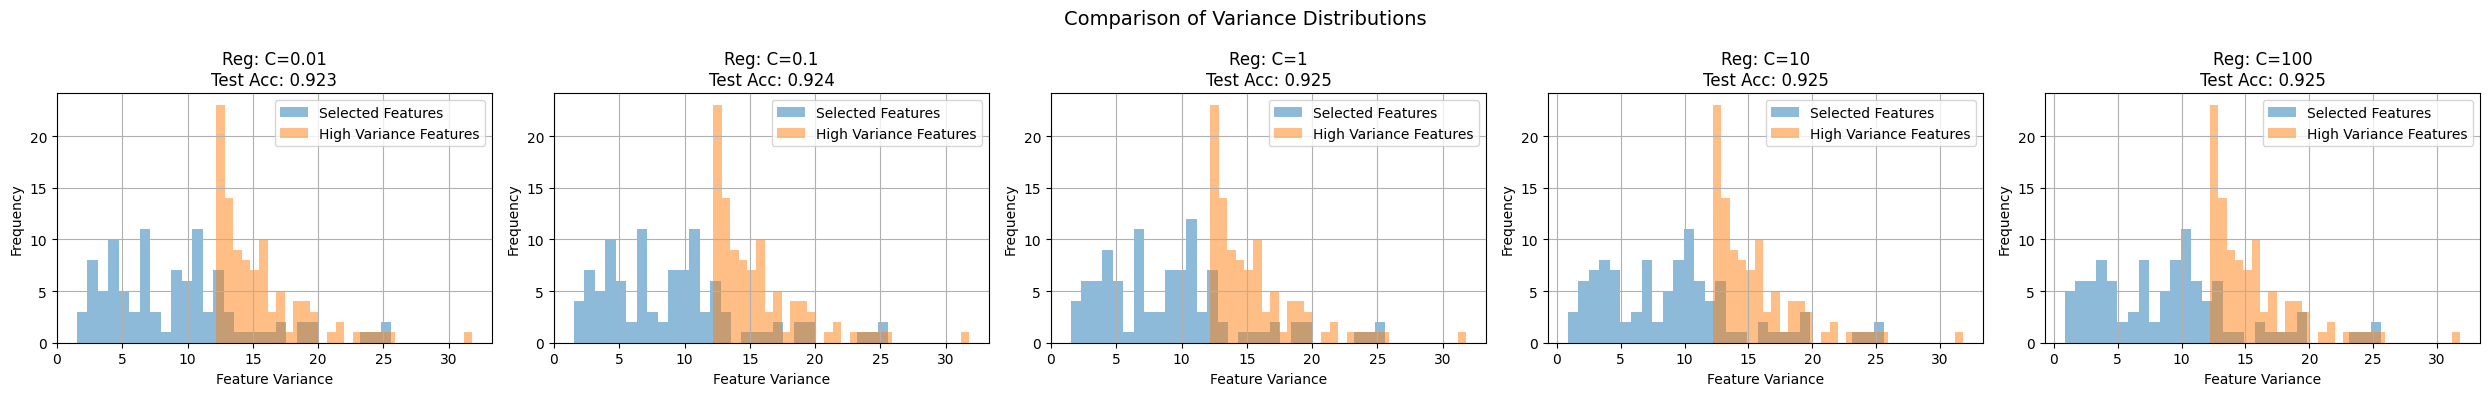

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Load Data
X_train = np.load("data/p2_evaluation_reduced/X_train.npy")
y_train = np.load("data/p2_evaluation_reduced/y_train.npy")
X_test = np.load("data/p2_evaluation_reduced/X_test.npy")
y_test = np.load("data/p2_evaluation_reduced/y_test.npy")

# Apply log transformation
X_train = np.log2(X_train + 1)
X_test = np.log2(X_test + 1)

# Define regularization strengths
regularization_strengths = [0.01, 0.1, 1, 10, 100]

# Create subplots
fig, axes = plt.subplots(1, len(regularization_strengths), figsize=(25, 4))

for i, C in enumerate(regularization_strengths):
    # Train Logistic Regression with L2 Regularization
    logreg = LogisticRegressionCV(Cs=[C], penalty='l2', solver='liblinear', cv=3, max_iter=500)
    logreg.fit(X_train, y_train)

    # Predict on test set
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)  # Compute Accuracy

    # Get feature importance
    coef_importance = np.abs(logreg.coef_).max(axis=0)
    top_100_features = np.argsort(coef_importance)[-100:]


    axes[i].hist(feature_variances[top_100_features], bins=30, alpha=0.5, label="Selected Features")
    axes[i].hist(feature_variances[top_100_var_features], bins=30, alpha=0.5, label="High Variance Features")
    axes[i].set_xlabel("Feature Variance")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
    axes[i].grid()
    # # Plot feature importance
    # axes[i].bar(range(len(feature_importance)), feature_importance)
    axes[i].set_title(f'Reg: C={C}\nTest Acc: {accuracy:.3f}')
    # axes[i].set_xlabel("Feature Index")
    # axes[i].set_ylabel("Importance")
    # axes[i].grid(True)

plt.suptitle("Comparison of Variance Distributions", fontsize=14)
plt.tight_layout()
plt.show()


Distribution of variances for top 100 features selected by weight (blue) vs. top 100 by variance (orange) for different regularization strength C. The features with highest importance appear to be agnostic of C.

#### Results:
- Test accuracy remains largely stable across C values.
- However, selected features tend to have **low variance**, regardless of C.
- This is in contrast to naive high-variance feature selection.

In [ ]:
# C=1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load Data
X_train = np.load("data/p2_evaluation_reduced/X_train.npy")
y_train = np.load("data/p2_evaluation_reduced/y_train.npy")
X_test = np.load("data/p2_evaluation_reduced/X_test.npy")
y_test = np.load("data/p2_evaluation_reduced/y_test.npy")

# Apply log transformation (to handle skewness)
X_train = np.log2(X_train + 1)
X_test = np.log2(X_test + 1)


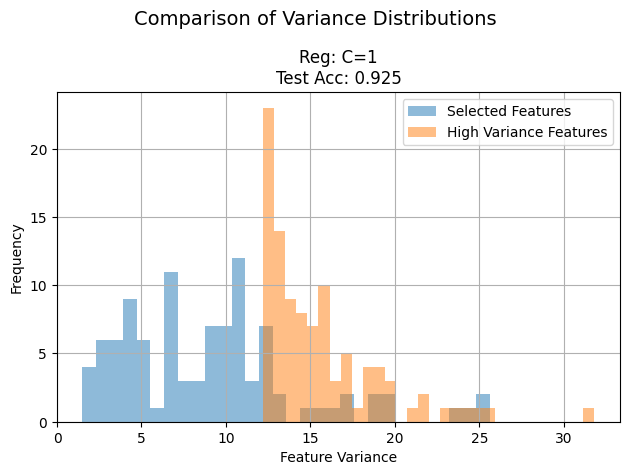

In [ ]:
plt.hist(feature_variances[top_100_features], bins=30, alpha=0.5, label="Selected Features")
plt.hist(feature_variances[top_100_var_features], bins=30, alpha=0.5, label="High Variance Features")
plt.xlabel("Feature Variance")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
# # Plot feature importance
# axes[i].bar(range(len(feature_importance)), feature_importance)
plt.title(f'Reg: C={C}\nTest Acc: {accuracy:.3f}')
# axes[i].set_xlabel("Feature Index")
# axes[i].set_ylabel("Importance")
    # axes[i].grid(True)

plt.suptitle("Comparison of Variance Distributions", fontsize=14)
plt.tight_layout()
plt.show()

Variance comparison for C=1 (uniform regularization across classes)

In [ ]:
logreg.C_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

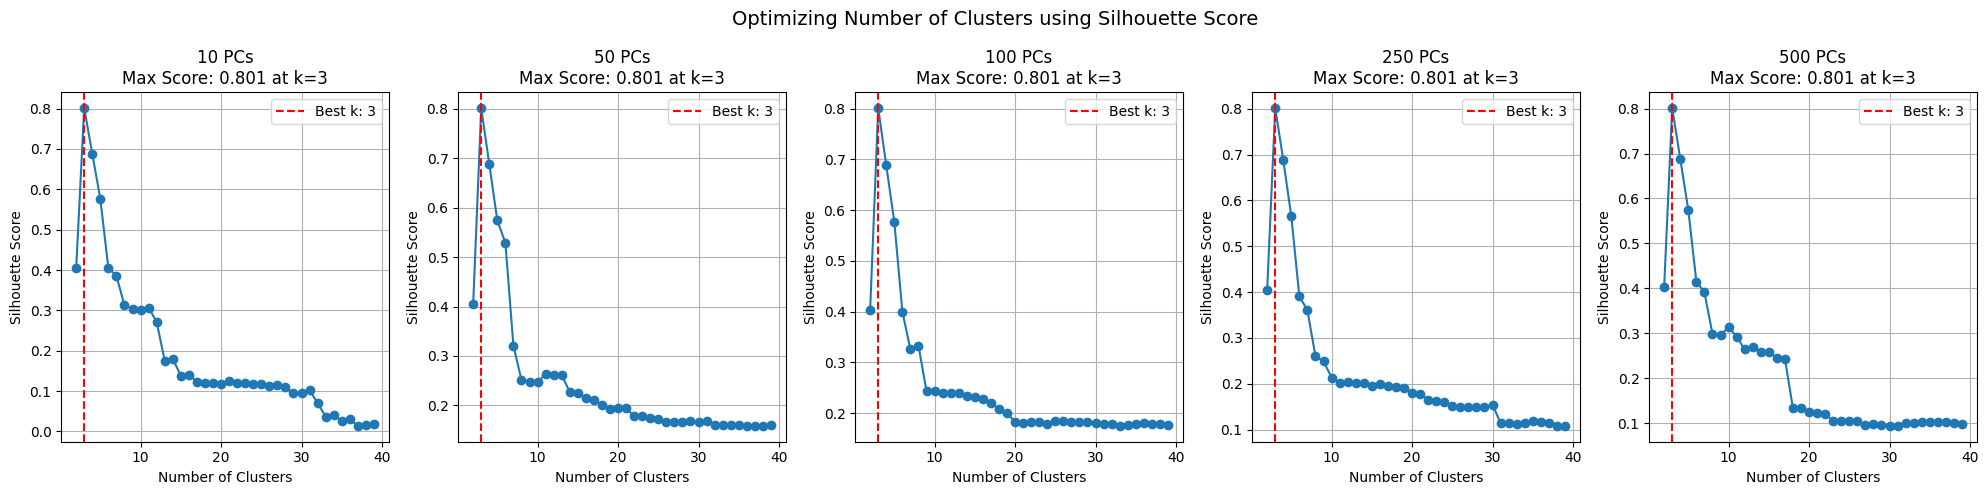

In [ ]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")
X = np.log2(X+1)
pca = PCA().fit(X)
z = pca_log.transform(X)

# List of Principal Components to analyze
npc_values = [10, 50, 100, 250, 500]
# n_clusters = 5  # Define the number of clusters
cluster_range = range(2, 40)  # Testing 2 to 9 clusters

# Initialize figure for subplots
fig, axes = plt.subplots(1, len(npc_values), figsize=(20, 5))

for i, npc in enumerate(npc_values):
    silhouette_scores = []

    for n_clusters in cluster_range:
        # Apply Agglomerative Clustering
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        cluster_labels = agg_cluster.fit_predict(z[:,0:npc])

        # Compute Silhouette Score
        score = silhouette_score(z_tsne, cluster_labels)
        silhouette_scores.append(score)

    max_score = max(silhouette_scores)
    best_n_clusters = cluster_range[np.argmax(silhouette_scores)]

    axes[i].plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
    axes[i].axvline(best_n_clusters, color='r', linestyle='--', label=f"Best k: {best_n_clusters}")
    axes[i].set_title(f"{npc} PCs\nMax Score: {max_score:.3f} at k={best_n_clusters}")
    axes[i].set_xlabel("Number of Clusters")
    axes[i].set_ylabel("Silhouette Score")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Optimizing Number of Clusters using Silhouette Score", fontsize=14)
plt.tight_layout()
plt.show()
